In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import theano as T

In [5]:
from importlib import reload

In [6]:
import functions.plotting
reload(functions.plotting)

<module 'functions.plotting' from '/mnt/c/Users/faust/OneDrive - UvA/research_projects/2022_arglang/arglang_modelling/analysis/functions/plotting.py'>

In [22]:
from functions.argstrengths_fullstatespace import *
from functions.argstrengths import *
from functions.data_functions import get_and_clean_data_exp2
from functions.plotting import (
    calculate_arg_deltas, 
    calculate_info_deltas, 
    plot_compare_argstrength_maximin
)
from functions.helper_functions import calculate_pragmatic_speaker, get_costs
from os.path import exists, join, splitext, basename
from json import dump, load
from glob import glob

In [8]:
raw_data, data, list_possible_observations, possible_utterances = get_and_clean_data_exp2(
    pathdata_firstexp='../../arglang_exp/data_experiment1/data.csv',
    pathdata='../../arglang_exp/data_experiment2/data.csv'
)

0  were excluded because incompletely recorded
14  of the participants were excluded as they gave more than 4 false responses
113  of the observations in the included participants were excluded because literally false


In [9]:
path_to_model_output_folder = '../arglang_model_fitting/experiment2_traces'
path_to_argstrengths_folder = './argstrengths/'

In [10]:
# Participants remaining after exclusion
data['id'].unique().shape

(186,)

# Sanity check argstrengths on full state space

NOTE: These functions are similar to the ones in the `analysis_fixedarray.ipynb` file, but are changed where needed to accomodate for the variable array size. It was more convenient to just keep some repetition rather than generalize each function.

Basic measure of argstrength is:

\begin{align}
P([\![u]\!] \mid \gamma) 
&= \sum_{s \in S} \mathbb{I}_{[\![u]\!] }(s) P(s \mid \gamma)\\
&= \sum_{s \in [\![u]\!]} P(s \mid \gamma)\\
&= \sum_{s \in [\![u]\!]} \prod_{i \in s} \left( \binom{N}{i} \gamma^i (1-\gamma)^{N-i} \right) \\
&= \sum_{s \in [\![u]\!]} \left( \gamma^{\sum_{i \in s} i} (1-\gamma)^{\sum_{i \in s}N-i} \prod_{i \in s} \binom{N}{i} \right)
\end{align}

Where $\mathbb{I}_{[\![u]\!] }(s)$ iff $s \in [\![u]\!]$.

The problem with implementing this formula directly is that for high values of $N$ and $|s|$, the number of states becomes so massive that it cannot be enumerated. In order to implement the calculation more efficiently, we can note that both the binomial probability _and_ the semantic function depend on the number of elements of $s$ with each possible number, but not on the way they are arranged. Therefore, instead of calculating each possible state individually, we calculate only the cells of the partition "equality under sorting", and then use the multinomial coefficient to compute how many elements are in each cell.  

\begin{align}
P([\![u]\!] \mid \gamma) 
&= \sum_{ s \in S\setminus{\sim}} \mathbb{I}_{[\![u]\!] }(s) \binom{K}{k_1 ... k_n} \left( \gamma^{\sum_{i \in s} i} (1-\gamma)^{\sum_{i \in s}N-i} \prod_{i \in s} \binom{N}{i} \right)
\end{align}

Where:
- $S\setminus{\sim}$ is (abusing the notation) a set of representatives (i.e., it contains one element from each cell of the equivalence class "same under ordering").
- $K$ is the number of students.
- $\binom{K}{k_1 ... k_n}$ is the number of elements in the partition of $s$. This is the multinomial coefficient with the counts of the unique elements in the state (e.g., for state $(12, 12, 12, 4, 4)$ this would be $\frac{5!}{3!2!}$.
- $N$ is the number of question

$S\setminus{\sim}$ is still going to get big quickly, but it works for the numbers in our experiment!

Lr argstrengths:

In [24]:
print(calculate_argumentative_strength_fullstatespace(
    possible_utterances,
    list_possible_observations[0],
    gamma_prove=0.85,
    gamma_disprove=0.15,
    savefolder=path_to_argstrengths_folder
))

[ 7.67164936e-01 -7.67164936e-01 -1.04076063e+02  1.04076063e+02
 -2.68601178e+01  2.68601178e+01 -7.67164936e-01  7.67164936e-01
 -2.05317694e+01  2.05317694e+01  5.82301873e-05 -5.82301873e-05
  5.69697101e+00 -5.69697101e+00  2.05317694e+01 -2.05317694e+01
 -6.22209645e+01  6.22209645e+01  2.32566526e-02 -2.32566526e-02
  1.96136164e+01 -1.96136164e+01  6.22209645e+01 -6.22209645e+01
 -1.04076063e+02  1.04076063e+02  7.67164936e-01 -7.67164936e-01
  3.65020613e+01 -3.65020613e+01  1.04076063e+02 -1.04076063e+02]


In [6]:
print(calculate_argumentative_strength_slow_fullstatespace(
    possible_utterances,
    list_possible_observations[0],
    gamma_prove=0.85,
    gamma_disprove=0.15,
))

[ 7.67164936e-01 -7.67164936e-01 -1.04076063e+02  1.04076063e+02
 -2.68601178e+01  2.68601178e+01 -7.67164936e-01  7.67164936e-01
 -2.05317694e+01  2.05317694e+01  5.82301874e-05 -5.82301873e-05
  5.69697101e+00 -5.69697101e+00  2.05317694e+01 -2.05317694e+01
 -6.22209645e+01  6.22209645e+01  2.32566526e-02 -2.32566526e-02
  1.96136164e+01 -1.96136164e+01  6.22209645e+01 -6.22209645e+01
 -1.04076063e+02  1.04076063e+02  7.67164936e-01 -7.67164936e-01
  3.65020613e+01 -3.65020613e+01  1.04076063e+02 -1.04076063e+02]


Maximin argstrengths:

In [6]:
calculate_maximin_argstrength_fullstatespace(
    possible_utterances=possible_utterances, 
    possible_observations=list_possible_observations[0], 
    gamma_prove=0.85, 
    gamma_disprove=0.15,
    savefolder=path_to_argstrengths_folder
)

array([-8.67300528e+01, -1.04076063e+02, -1.04076063e+02,  1.04076063e+02,
       -1.04076063e+02,  3.55271368e-15, -1.04076063e+02, -8.67300528e+01,
       -1.04076063e+02, -6.24456380e+01, -1.00606861e+02, -1.04076063e+02,
       -7.97916485e+01, -1.04076063e+02, -6.24456380e+01, -1.04076063e+02,
       -1.04076063e+02,  2.08152127e+01, -9.36684570e+01, -1.04076063e+02,
       -3.12228190e+01, -1.04076063e+02,  2.08152127e+01, -1.04076063e+02,
       -1.04076063e+02,  1.04076063e+02, -8.67300528e+01, -1.04076063e+02,
        1.73460106e+01, -1.04076063e+02,  1.04076063e+02, -1.04076063e+02])

In [19]:
calculate_maximin_argstrength_slow_fullstatespace(
    possible_utterances=possible_utterances, 
    possible_observations=list_possible_observations[0],
    gamma_prove=0.85, 
    gamma_disprove=0.15
)

/mnt/c/Users/faust/OneDrive - UvA/research_projects/2022_arglang/arglang_modelling/functions/argstrengths_fullstatespace.py:324: RuntimeWarning: invalid value encountered in subtract
  log_ratio = np.log(post_for) - np.log(post_against)


array([-8.67300528e+01, -1.04076063e+02, -1.04076063e+02,  1.04076063e+02,
       -1.04076063e+02,  3.55271368e-15, -1.04076063e+02, -8.67300528e+01,
       -1.04076063e+02, -6.24456380e+01, -1.00606861e+02, -1.04076063e+02,
       -7.97916485e+01, -1.04076063e+02, -6.24456380e+01, -1.04076063e+02,
       -1.04076063e+02,  2.08152127e+01, -9.36684570e+01, -1.04076063e+02,
       -3.12228190e+01, -1.04076063e+02,  2.08152127e+01, -1.04076063e+02,
       -1.04076063e+02,  1.04076063e+02, -8.67300528e+01, -1.04076063e+02,
        1.73460106e+01, -1.04076063e+02,  1.04076063e+02, -1.04076063e+02])

Nonparametric argstrengths:

In [20]:
calculate_nonparametric_argstrength_fullstatespace(
    possible_utterances=possible_utterances, 
    possible_observations=list_possible_observations[0], 
    condition='high',
    savefolder=path_to_argstrengths_folder
).flatten()

array([ 2.50000000e+00, -2.50000000e+00, -3.00000000e+01,  3.00000000e+01,
       -1.50000000e+01,  1.50000000e+01, -2.50000000e+00,  2.50000000e+00,
       -5.07982133e+00,  5.07982133e+00,  8.07989399e-05, -8.07989399e-05,
        7.11184645e-01, -7.11184645e-01,  5.07982133e+00, -5.07982133e+00,
       -1.72684877e+01,  1.72684877e+01,  7.00934579e-02, -7.00934579e-02,
        6.99048913e+00, -6.99048913e+00,  1.72684877e+01, -1.72684877e+01,
       -3.00000000e+01,  3.00000000e+01,  2.50000000e+00, -2.50000000e+00,
        1.75000000e+01, -1.75000000e+01,  3.00000000e+01, -3.00000000e+01])

In [115]:
calculate_nonparametric_argstrength_slow_fullstatespace(
    possible_utterances=possible_utterances, 
    possible_observations=list_possible_observations[0], 
    condition='high'
).flatten()

array([ 2.50000000e+00, -2.50000000e+00, -3.00000000e+01,  3.00000000e+01,
       -1.50000000e+01,  1.50000000e+01, -2.50000000e+00,  2.50000000e+00,
       -5.07982133e+00,  5.07982133e+00,  8.07989399e-05, -8.07989399e-05,
        7.11184645e-01, -7.11184645e-01,  5.07982133e+00, -5.07982133e+00,
       -1.72684877e+01,  1.72684877e+01,  7.00934579e-02, -7.00934579e-02,
        6.99048913e+00, -6.99048913e+00,  1.72684877e+01, -1.72684877e+01,
       -3.00000000e+01,  3.00000000e+01,  2.50000000e+00, -2.50000000e+00,
        1.75000000e+01, -1.75000000e+01,  3.00000000e+01, -3.00000000e+01])

# Save remaining argstrengths and store them all in csv

The code above automatically saves all the full state space argstrengths (when ran for all parameters). Here I save the remaining argstrengths.

In [1]:
folder_exp2_traces = '../../arglang_model_fitting/experiment2_traces'
# where to store the argstrengths, since some of them take a while to compute
# (namely, the ones with full state space)
path_to_argstrengths_folder = './argstrengths/'
folder_exp2_cleaned_data = '../data/data_experiment2/'

In [2]:
folder_exp1_data = '../../arglang_exp/data_experiment1/data.csv'
folder_exp2_data = '../../arglang_exp/data_experiment2/data.csv'

In [11]:
exp1and2_data = get_and_clean_data_exp2(
    pathdata_firstexp=folder_exp1_data,
    pathdata=folder_exp2_data
)
_, data, list_possible_observations, possible_utterances = exp1and2_data

0  were excluded because incompletely recorded
14  of the participants were excluded as they gave more than 4 false responses
113  of the observations in the included participants were excluded because literally false


In [16]:
if exists(folder_exp2_data):
    exp1and2_data = get_and_clean_data_exp2(
        pathdata_firstexp=folder_exp1_data,
        pathdata=folder_exp2_data
    )
    _, data, list_possible_observations, possible_utterances = exp1and2_data
    data.to_csv(join(folder_exp2_cleaned_data, 'cleaned_data_1and2.csv'), index=False)
    with open(join(folder_exp2_cleaned_data, 'obs_1and2.json'),'w') as openfile:
        dump([x.tolist() for x in list_possible_observations], openfile)
    pd.DataFrame(possible_utterances).to_csv(join(folder_exp2_cleaned_data, 'utts.csv'), index=False)
else:
    # read the pre-cleaned data
    data = pd.read_csv(join(folder_exp2_cleaned_data, 'cleaned_data_1and2.csv'))
    list_possible_observations = pd.read_json(join(folder_exp2_cleaned_data, 'obs_1and2.json')).to_numpy()
    with open(join(folder_exp2_cleaned_data, 'obs_1and2.json'), 'r') as openfile:
        y = load(openfile)
    list_possible_observations = [np.array(x) for x in y]
    possible_utterances = pd.read_csv(join(folder_exp2_cleaned_data, 'utts.csv')).to_numpy()

0  were excluded because incompletely recorded
14  of the participants were excluded as they gave more than 4 false responses
113  of the observations in the included participants were excluded because literally false


In [27]:
for possible_observations in list_possible_observations:
    
    nanswers  = int(possible_observations.max())
    nstudents = possible_observations.shape[1]
    
    for gammaprove, gammadisprove in [(0.85, 0.15), (0.15, 0.85)]:
    
        savename = f"argstrengths/kind=lr-nanswers={nanswers}-nstudents={nstudents}-gammaprove={gammaprove}-gammadisprove={gammadisprove}"
        argstrength = calculate_argumentative_strength(possible_utterances, possible_observations, 0.85, 0.15)
        with open(savename, "wb") as f:
            np.save(f, argstrength)

        savename = f"argstrengths/kind=maximin_raw-nanswers={nanswers}-nstudents={nstudents}-gammaprove={gammaprove}-gammadisprove={gammadisprove}"
        argstrength = calculate_maximin_argstrength(possible_utterances, possible_observations, 0.85, 0.15)
        with open(savename, "wb") as f:
            np.save(f, argstrength)
    
    for condition in ['high', 'low']:
        savename = f"argstrengths/kind=nonparametric_raw-nanswers={nanswers}-nstudents={nstudents}-condition={condition}"
        argstrength = calculate_nonparametric_argstrength(possible_utterances, possible_observations, 'high')
        with open(savename, "wb") as f:
            np.save(f, argstrength)
    

In [28]:
argstrength_dict = dict()
for fpath in glob('./argstrengths/*.npy'):
    name = splitext(basename(fpath))[0]
    with open(fpath, 'rb') as openf:
        x = np.load(openf)
        argstrength_dict[name] = x

In [30]:
argstrengths_df = pd.DataFrame(argstrength_dict, index=possible_utterances)

In [31]:
argstrengths_df.to_csv('./argstrengths/argstrengths.csv')

# Display and compare argstrengths

I only needed to run this once to create the files with all the argstrenghts (since for the big array sizes it takes a while!).

```python
for possible_observations in list_possible_observations:
    for gamma_for, gamma_against in [(0.15, 0.85), (0.85, 0.15)]:
        calculate_argumentative_strength(
            possible_utterances, 
            possible_observations, 
            gamma_for, 
            gamma_against,
            path_to_argstrengths_folder
        )
        
        calculate_maximin_argstrength(
            possible_utterances=possible_utterances, 
            possible_observations=possible_observations, 
            gamma_prove=gamma_for, 
            gamma_disprove=gamma_against,
            savefolder=path_to_argstrengths_folder
        )
```

### Plot argstrengths by array size

In [7]:
utterance_observation_compatibility = np.stack(
    [
            np.stack([
            verify(
                *a, 
                possible_observations,
                n_answers=possible_observations.max(),
                n_students=possible_observations.shape[1]
            )
            for a in possible_utterances
        ])
    for possible_observations in list_possible_observations
    ]
)

Defining non-hierarchical model


/mnt/c/Users/faust/OneDrive - UvA/research_projects/2022_arglang/arglang_modelling/functions/argstrengths.py:148: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)


Defining non-hierarchical model
Defining non-hierarchical model
Defining non-hierarchical model


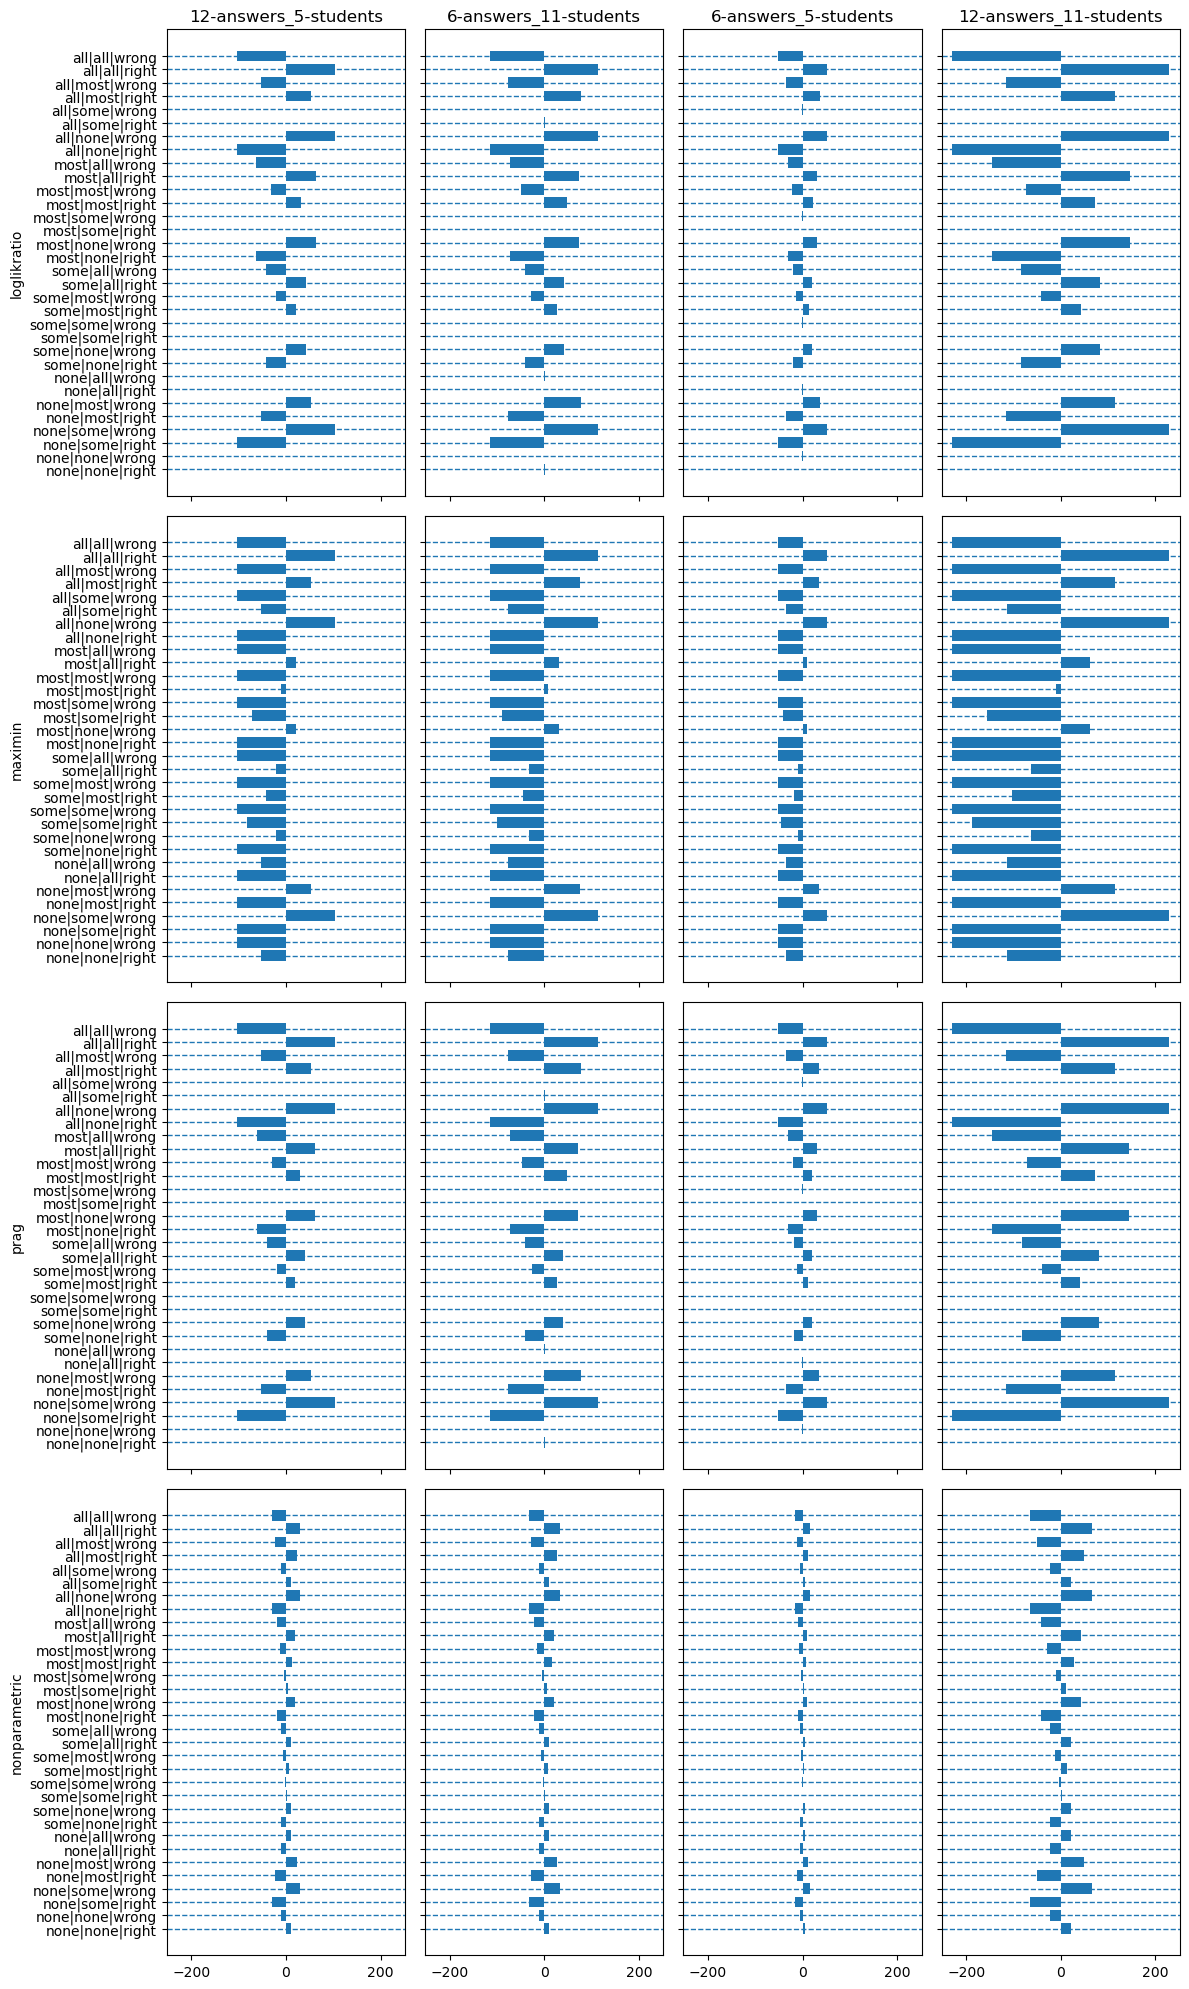

In [15]:
fig, axes = plt.subplots(4,4, sharey=True, sharex=True, figsize=(12,20))

utts = np.apply_along_axis(
    lambda x: '|'.join(x),
    1,
    possible_utterances
)

for i, possible_observations in enumerate(list_possible_observations):

    loglikratio_argstrengths_positive = calculate_argumentative_strength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.85, 
        gamma_disprove=0.15,
    )
    axes[0,i].barh(
        np.arange(32),
        loglikratio_argstrengths_positive
    )

    maximin_argstrengths_positive = calculate_maximin_argstrength(
        possible_utterances, 
        possible_observations, 
        gamma_prove=0.85, 
        gamma_disprove=0.15
    )
    axes[1,i].barh(
        np.arange(32),
        maximin_argstrengths_positive
    )

    costs = np.array([
        3 if 'none' in utt
        else 0
        for utt in possible_utterances
    ])
    prag_argstrengths_positive = theano_calculate_pragmatic_argstrength(
        possible_utterances, 
        possible_observations,
        gamma_prove=0.85, 
        gamma_disprove=0.15,
        alpha=T.shared(3.),
        costs=T.shared(costs),
    ).eval()
    axes[2,i].barh(
        np.arange(32),
        prag_argstrengths_positive
    )

    nonpar_argstrengths_positive = calculate_nonparametric_argstrength(
        possible_utterances, 
        possible_observations, 
        condition='high'
    ).flatten()
    axes[3,i].barh(
        np.arange(32),
        nonpar_argstrengths_positive
    )
    
    n_answers = possible_observations.max()
    n_students = possible_observations.shape[1]
    axes[0,i].set_title(f'{n_answers}-answers_{n_students}-students')

[
    (
        ax.set_ylabel(name), 
        ax.set_yticks(range(len(utts))), 
        ax.set_yticklabels(utts)
    ) 
    for ax, name in zip(
        axes[:,0],
        ['loglikratio', 'maximin', 'prag', 'nonparametric']
    )
]

for ax in axes.flatten():
    [
        ax.axhline(y=i, linestyle='--', lw=1) 
        for i in range(32)
    ]

plt.tight_layout()
# fig.savefig('figs/variable_array_size_argstrengths.png', dpi=300)

### Plot lr-argstrengths

In [7]:
possible_observations = list_possible_observations[0]

In [18]:
argumentative_strengths_positive = calculate_argumentative_strength(
    possible_utterances, 
    possible_observations,
    0.85, 0.15,
)

argumentative_strengths_negative = calculate_argumentative_strength(
    possible_utterances, 
    possible_observations,
    0.15, 0.85,
)

In [21]:
info_deltas = calculate_info_deltas(
    possible_utterances, 
    possible_observations
)

arg_deltas_negative = calculate_arg_deltas(
    argumentative_strengths_negative,
    possible_observations, 
    possible_utterances
)

arg_deltas_positive = calculate_arg_deltas(
    argumentative_strengths_positive,
    possible_observations, 
    possible_utterances
)

/mnt/c/Users/faust/OneDrive - UvA/research_projects/2022_arglang/arglang_modelling/functions/plotting.py:59: RuntimeWarning: divide by zero encountered in log
  informativity = np.log(p_observation_given_utterance)


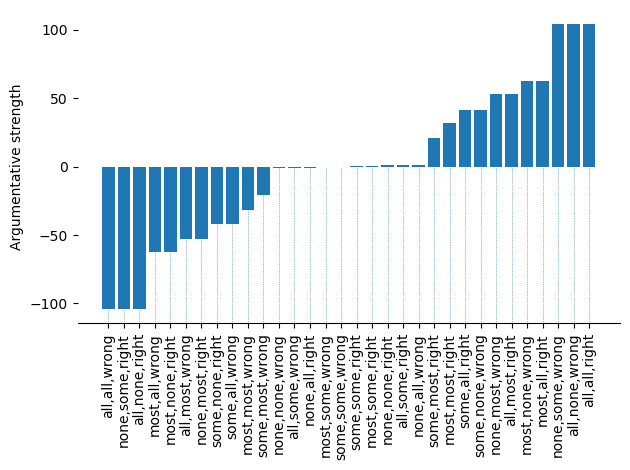

In [12]:
# calculate and plot the argumentative strengths
# for all possible signals, in the high condition
argumentative_strengths = calculate_argumentative_strength(
    possible_utterances, possible_observations,
    0.85, 0.15
)

fig, ax = plt.subplots()

argsort = np.argsort(argumentative_strengths)
ax.bar(np.arange(len(argumentative_strengths)), argumentative_strengths[argsort])
ax.set_xticks(range(len(argumentative_strengths)))
xlabels = [','.join(a) for a in possible_utterances]
ax.set_xticklabels(np.array(xlabels)[argsort], rotation=90)
ax.set_ylabel(r'Argumentative strength')
# plt.show()

for x in ax.get_xticks():
    ax.axvline(
        x=x,
        ymax=0.5,
        ls=':',
        lw=0.5
    )

sns.despine(ax=ax, left=True)

fig.tight_layout()
fig.savefig('./figs/various/argstrengths.png', dpi=300)

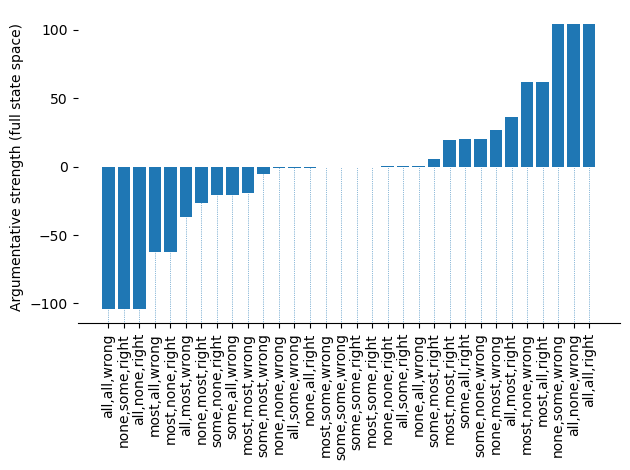

In [9]:
# calculate and plot the argumentative strengths
# for all possible signals, in the high condition
argumentative_strengths_fullstatespace = calculate_argumentative_strength_fullstatespace(
    possible_utterances, possible_observations,
    0.85, 0.15
)

fig, ax = plt.subplots()

argsort = np.argsort(argumentative_strengths_fullstatespace)
ax.bar(np.arange(len(argumentative_strengths_fullstatespace)), argumentative_strengths_fullstatespace[argsort])
ax.set_xticks(range(len(argumentative_strengths_fullstatespace)))
xlabels = [','.join(a) for a in possible_utterances]
ax.set_xticklabels(np.array(xlabels)[argsort], rotation=90)
ax.set_ylabel(r'Argumentative strength (full state space)')
# plt.show()

for x in ax.get_xticks():
    ax.axvline(
        x=x,
        ymax=0.5,
        ls=':',
        lw=0.5
    )

sns.despine(ax=ax, left=True)

fig.tight_layout()
fig.savefig('./figs/various/argstrengths_fullstatespace.png', dpi=300)

In [13]:
argstrengths_array = np.array([
    calculate_argumentative_strength(
        possible_utterances, possible_observations,
        gamma, 1-gamma
    )
    for gamma 
    in np.linspace(0,1,50)
])

/mnt/c/Users/faust/OneDrive - UvA/research_projects/2022_arglang/arglang_modelling/functions/argstrengths.py:71: RuntimeWarning: divide by zero encountered in log
  np.log(
/mnt/c/Users/faust/OneDrive - UvA/research_projects/2022_arglang/arglang_modelling/functions/argstrengths.py:78: RuntimeWarning: divide by zero encountered in log
  np.log(


Most of the signals have consistent ordering of argstrength across all values of $\gamma$ (flipped at 0.5, as expected). However, there's two signals that change ordering:

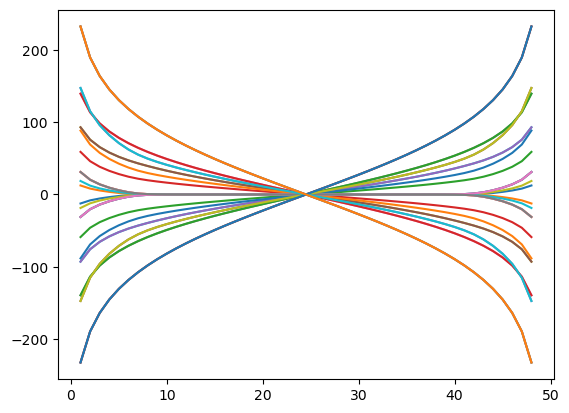

In [14]:
plt.plot(argstrengths_array)
plt.show()

### Plot $S_1$ with an lr-argstrength

In [48]:
argumentative_strengths_full_statespace = calculate_argumentative_strength_fullstatespace(
    possible_utterances, 
    possible_observations,
    0.85, 0.15,
)

argumentative_strengths = calculate_argumentative_strength(
    possible_utterances, 
    possible_observations,
    0.85, 0.15,
)

[9 9 3 0 0]


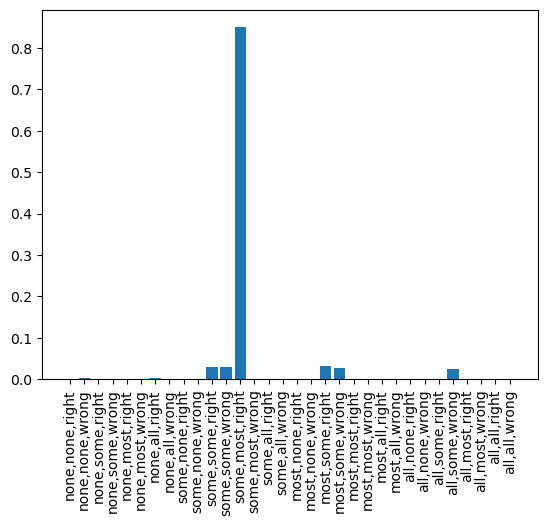

In [49]:
# calculate the probability of the pragmatic speaker 
# producing each utterance for a specific observation.

utterance_observation_compatibility = np.stack([
    verify(*a, possible_observations)
    for a in possible_utterances
])

p_observation_given_utterance = (
    utterance_observation_compatibility / 
    utterance_observation_compatibility.sum(0, keepdims=True)
)

p_utterance_given_observation = calculate_pragmatic_speaker(
    argumentative_strengths, 
    p_observation_given_utterance,
    costs=get_costs(possible_utterances), 
    alpha=0.8, 
    beta=0.8
)

index_observation = 17

print(possible_observations[index_observation])

fig, ax = plt.subplots()
ax.bar(
    np.arange(len(p_utterance_given_observation[:,index_observation])), 
    p_utterance_given_observation[:,index_observation]
)
ax.set_xticks(range(32))
ax.set_xticklabels(xlabels, rotation=90)
plt.show()

[9 9 3 0 0]


/mnt/c/Users/faust/OneDrive - UvA/research_projects/2022_arglang/arglang_modelling/functions/helper_functions.py:232: RuntimeWarning: divide by zero encountered in log
  """


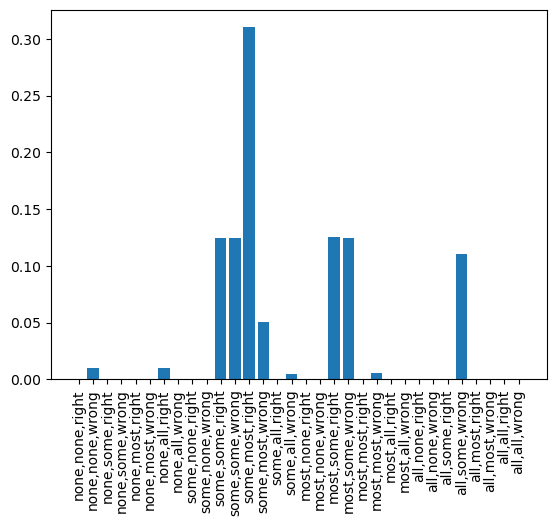

In [50]:
# calculate the probability of the pragmatic speaker 
# producing each utterance for a specific observation.

utterance_observation_compatibility = np.stack([
    verify(*a, possible_observations)
    for a in possible_utterances
])

p_observation_given_utterance = (
    utterance_observation_compatibility / 
    utterance_observation_compatibility.sum(0, keepdims=True)
)

p_utterance_given_observation = calculate_pragmatic_speaker(
    argumentative_strengths_full_statespace, 
    p_observation_given_utterance,
    costs=get_costs(possible_utterances), 
    alpha=0.8, 
    beta=0.8
)

index_observation = 17

print(possible_observations[index_observation])

fig, ax = plt.subplots()
ax.bar(
    np.arange(len(p_utterance_given_observation[:,index_observation])), 
    p_utterance_given_observation[:,index_observation]
)
ax.set_xticks(range(32))
ax.set_xticklabels(xlabels, rotation=90)
plt.show()

### Compare maximin and lr argstrengths

Compare the maximin-argstrength of all signals when arguing against the 'opposite' claim (e.g. 0.85, 0.15).

/mnt/c/Users/faust/OneDrive - UvA/research_projects/2022_arglang/arglang_modelling/functions/argstrengths.py:148: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)


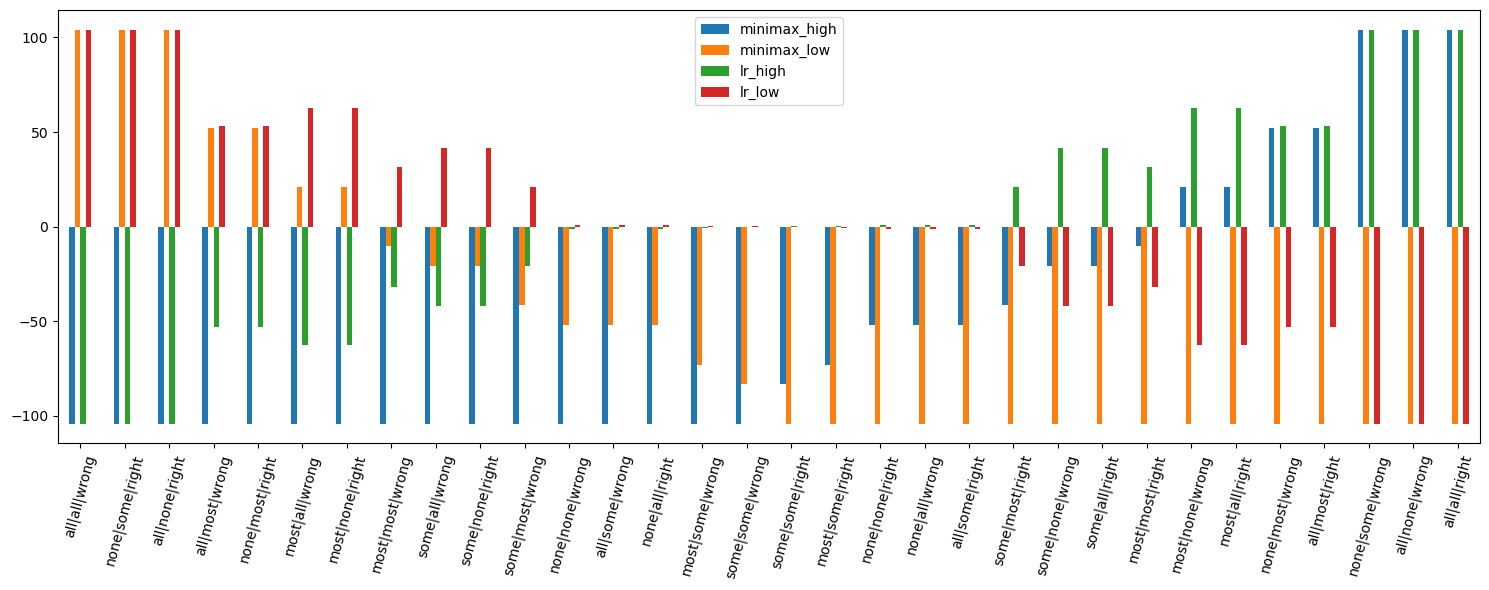

In [21]:
plot_compare_argstrength_maximin(
    0.85, 0.15,
    possible_utterances, possible_observations
)

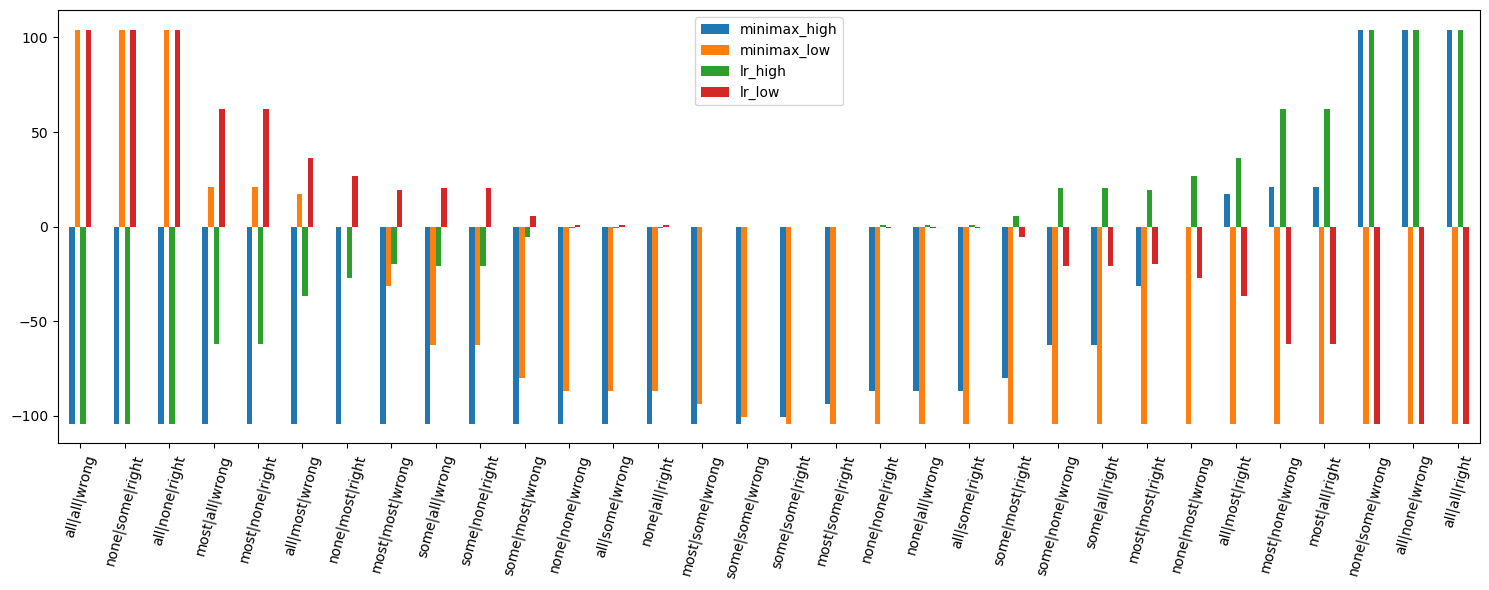

In [22]:
plot_compare_argstrength_maximin(
    0.85, 0.15,
    possible_utterances, possible_observations,
    True
)

Compare the maximin-argstrength of all signals when arguing against the 'neutral' claim (e.g. 0.9, 0.5).

/mnt/c/Users/faust/OneDrive - UvA/research_projects/2022_arglang/arglang_modelling/functions/argstrengths.py:148: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)


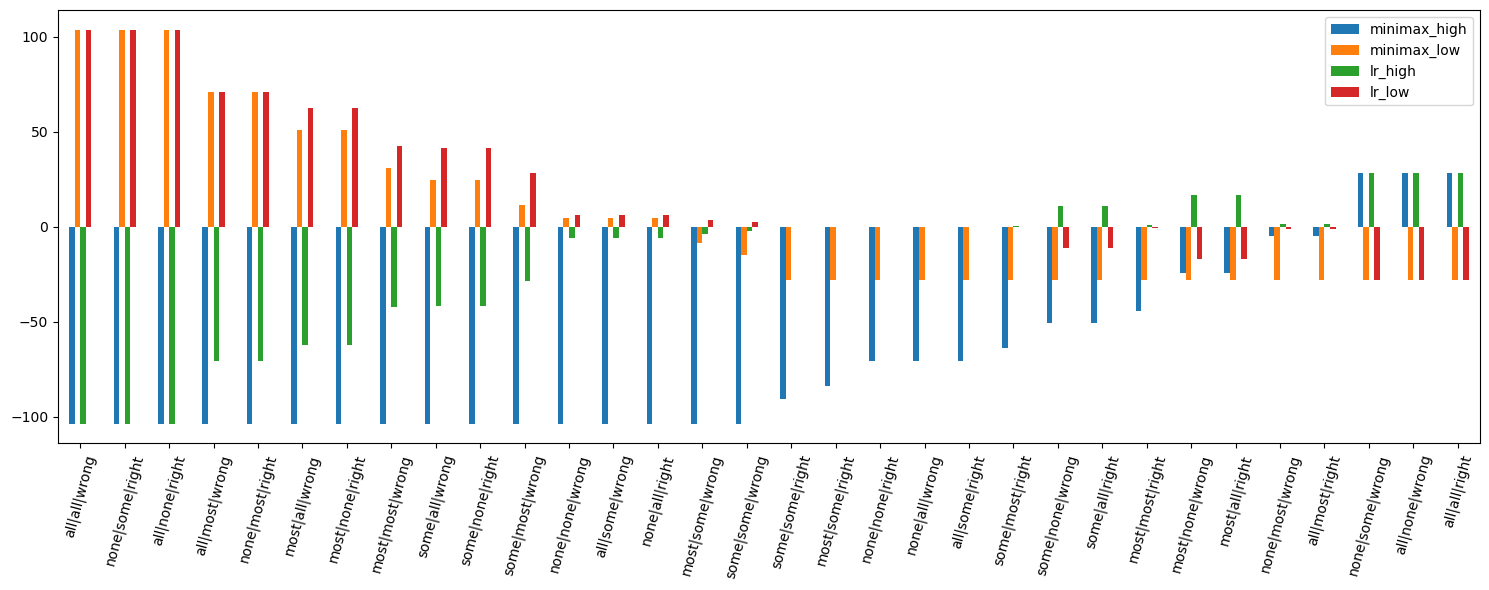

In [23]:
plot_compare_argstrength_maximin(
    0.9, 0.5,
    possible_utterances, possible_observations
)

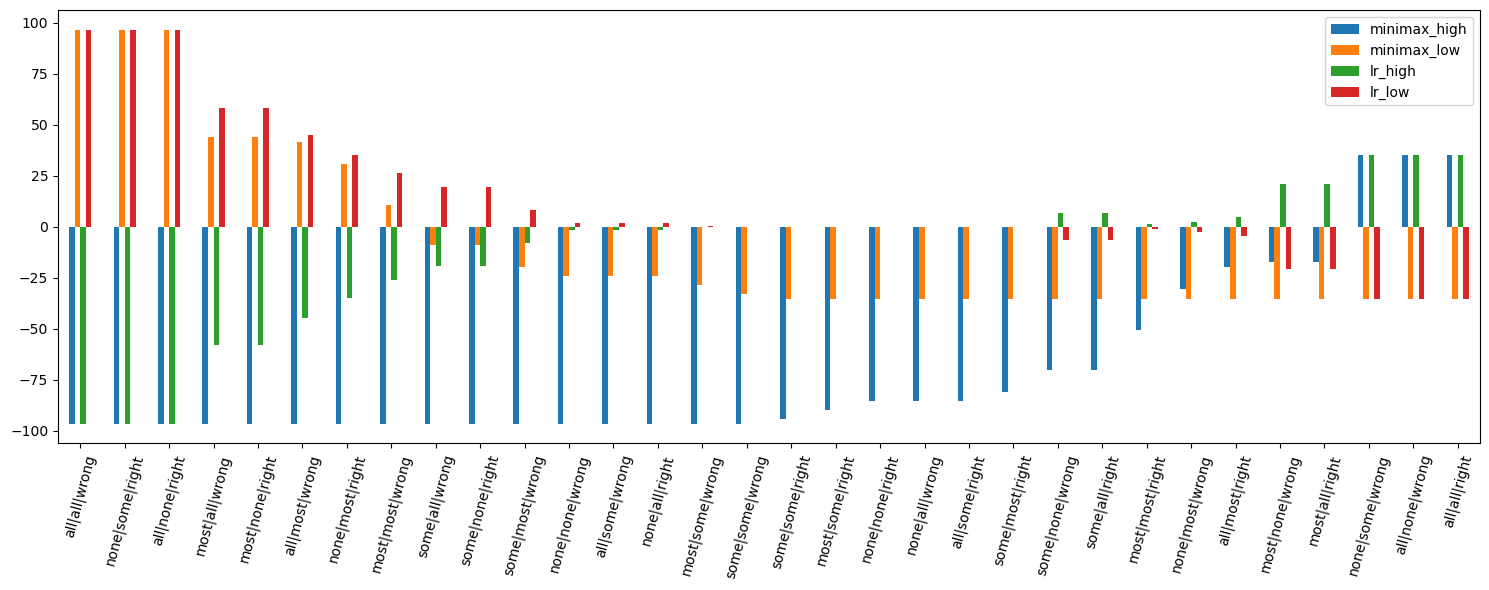

In [24]:
plot_compare_argstrength_maximin(
    0.9, 0.5,
    possible_utterances, possible_observations,
    True
)

### Check changes in the index of maximin obs depending on gamma

In [88]:
argmins = []
for gamma_prove in np.linspace(0.001,0.999,1000):
    
    gamma_disprove = 1-gamma_prove
    
    utterance_observation_compatibility = np.stack([
        functions.verify(*a, possible_observations)
        for a in possible_utterances
    ])
    utterance_observation_compatibility = np.where(
        utterance_observation_compatibility == 0,
        np.inf,
        utterance_observation_compatibility
    )
    
    # dimensions (utterances, observations)
    logp_for = np.log(calculate_p_obs_given_utterance_and_gamma_maximin(
        possible_observations, 
        utterance_observation_compatibility, 
        gamma_prove
    ))
    
    logp_against = np.log(calculate_p_obs_given_utterance_and_gamma_maximin(
        possible_observations, 
        utterance_observation_compatibility, 
        gamma_disprove
    ))
    
    # argmin finds the index of the observation that is argumentatively worst
    argmins.append(np.nanargmin(logp_for-logp_against, 1))
argmins = np.array(argmins)

/tmp/ipykernel_5222/1854795150.py:30: RuntimeWarning: invalid value encountered in subtract
  argmins.append(np.nanargmin(logp_for-logp_against, 1))


The plot makes it clear that there is a switch of the indices at 0.5 for most signals, and that's it, which actually makes sense, because that's where $\gamma$ goes from arguing for 'participants are good' to arguing for 'participants are bad'. 

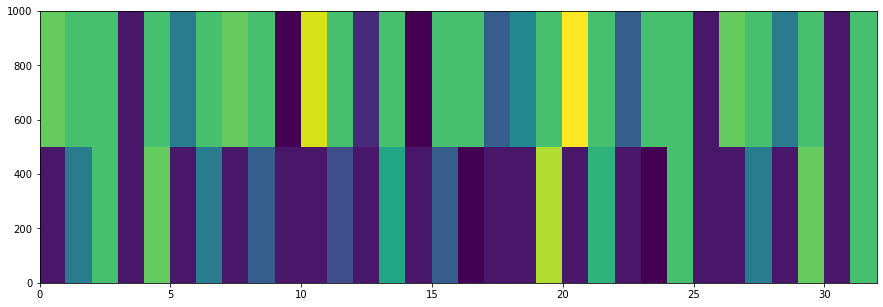

In [89]:
fig, ax = plt.subplots(figsize=(15,5))
ax.pcolor(argmins)

Question: What is, for each possible utterance, the observation considered by the minimax speaker to calculate the argstrength?

In [90]:
utt_arr = np.apply_along_axis(lambda x: '|'.join(x), 1, possible_utterances)

In [91]:
pd.DataFrame(
    np.column_stack((
        utt_arr,
        possible_observations[argmins[-1]]
    )),
)

,0,1,2,3,4,5
0,none|none|right,3,3,3,3,3
1,none|none|wrong,0,0,0,0,0
2,none|some|right,0,0,0,0,0
3,none|some|wrong,12,12,12,12,12
4,none|most|right,0,0,0,0,0
5,none|most|wrong,9,9,9,9,9
6,none|all|right,0,0,0,0,0
7,none|all|wrong,3,3,3,3,3
8,some|none|right,0,0,0,0,0
9,some|none|wrong,12,12,0,0,0


### Plot maximin argstrength as a function of $\gamma$

In [265]:
acc_argstrengths = np.array([
    calculate_maximin_argstrength(
        possible_utterances, 
        possible_observations, 
        gamma_prove, 
        1-gamma_prove
    )
    for gamma_prove 
    in np.linspace(0.001, 0.999, 50)
])

/tmp/ipykernel_1015/2413881708.py:63: RuntimeWarning: invalid value encountered in subtract
  return np.nanmin(logp_for-logp_against, 1)


Looks like all that $\gamma$ does (as long as it is kept in the 0.5 to 1. interval) is change how argumentatively strong a certain utterance is. This could mean that the $\beta$ parameter alone is sufficient.

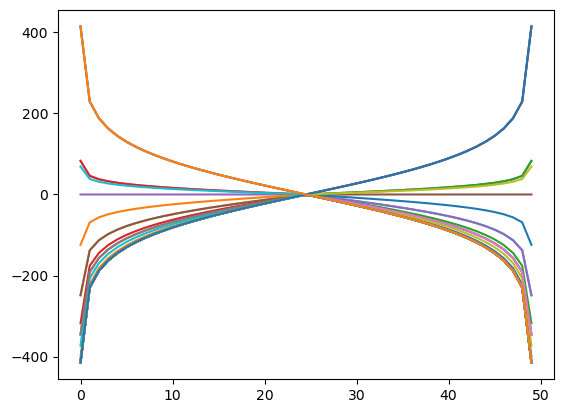

In [266]:
plt.plot(acc_argstrengths)
plt.show()